In [147]:
import pickle 
import yaml
import pandas as pd
from PrepareData import prepare_data


import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import seaborn as sns
from architecture import CLIP
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [148]:
from train_utils import load_model

In [149]:
val_ids = pickle.load(open('./checkpoints/FULL_COMBINED/val_ids.pickle', 'rb'))

In [150]:
def make_deterministic(random_seed = 0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

In [151]:
make_deterministic(0)

In [153]:
config = yaml.safe_load(open('./checkpoints/FULL_COMBINED/config.yaml', 'r'))
logs = pickle.load(open('./checkpoints/FULL_COMBINED/logs.pickle', 'rb'))
for key in logs:
    if "best" in key:
        print(key, logs[key])

best_epoch 618
best_clip_epoch 684
best_recon_epoch 195
best_total_loss 0.05993457242846489
best_clip_loss 0.012829888865817339
best_recon_loss 0.039655369743704795


In [154]:
model = load_model(config['train']['checkpoint_dir'], type="best_recon")
model.eval()
dataloaders, max_charge, num_species = prepare_data(config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

SMILES WILL BE RANDOMIZED


In [155]:
all_ids = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
        all_ids.append(ids.detach().cpu())
all_ids = torch.cat(all_ids, 0)

0it [00:00, ?it/s]/home2/kanakala.ganesh/miniconda3/envs/sbdd-env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
50it [00:16,  2.96it/s]


In [156]:
count = 0
for id in val_ids:
    if id in all_ids:
        count += 1 
count

20000

In [157]:
trainmolembeds = []
trainspecembeds = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['train'])):    
        data = {k: v.to(device) for k, v in data.items()}
        mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
        trainmolembeds.append(mol_latents.detach().cpu())
        trainspecembeds.append(spec_latents.detach().cpu())
    del mol_latents, spec_latents, smile_preds, logit_scale, ids

250it [01:28,  2.84it/s]


In [158]:
testmolembeds = []
testspecembeds = []
testsmiles = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
        testmolembeds.append(mol_latents.detach().cpu())
        testspecembeds.append(spec_latents.detach().cpu())
        testsmiles.append(data['smiles'].detach().cpu())
    del mol_latents, spec_latents, smile_preds, logit_scale, ids

50it [00:18,  2.77it/s]


In [159]:
train_molembeds = torch.cat(trainmolembeds, 0)
train_specembeds = torch.cat(trainspecembeds, 0)
test_molembeds = torch.cat(testmolembeds, 0)
test_specembeds = torch.cat(testspecembeds, 0)

In [160]:
from train_utils import Sampler, calculate_decoder_accuracy
sampler = Sampler( model.module.smiles_decoder, model.module.vocab)

In [161]:
testrandomsmiles = sampler.sample_multi(n=3,embed=test_specembeds[0],greedy_decode=False)
trainrandomsmiles = sampler.sample_multi(n=3,embed=train_specembeds[0],greedy_decode=False)

In [15]:
og_smiles_list = []
test_spec_smiles_list = []
test_mol_smiles_list = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        spec_latents = model.module.forward_spec(data)
        mol_latents = model.module.forward_mol(data)
        for spec, mol, og in zip(spec_latents, mol_latents, data['smiles'] ):
            og_smile = ""
            chars = model.module.vocab.from_seq(og)
            for char in chars:
                if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                    og_smile += char
            try:
                og_smile = Chem.CanonSmiles(og_smile)
            except:
                og_smile= None
            
            random_smiles = sampler.sample_multi(n=3,embed=spec,greedy_decode=False)
            test_spec_smiles_list.append(random_smiles)
            
            random_smiles = sampler.sample_multi(n=3,embed=mol,greedy_decode=False)
            test_mol_smiles_list.append(random_smiles)
            
            og_smiles_list.append(og_smile)
        break

0it [01:01, ?it/s]


In [16]:


arr = []
for og_smile, greedy_smiles, random_smiles in zip(og_smiles_list, test_spec_smiles_list, test_mol_smiles_list):
    try:
        v = [Chem.MolFromSmiles(og_smile)] + [Chem.MolFromSmiles(smi) for smi in greedy_smiles] + [Chem.MolFromSmiles(smi) for smi in random_smiles]
        for a in v:
            arr.append(a)   
    except:
        pass 

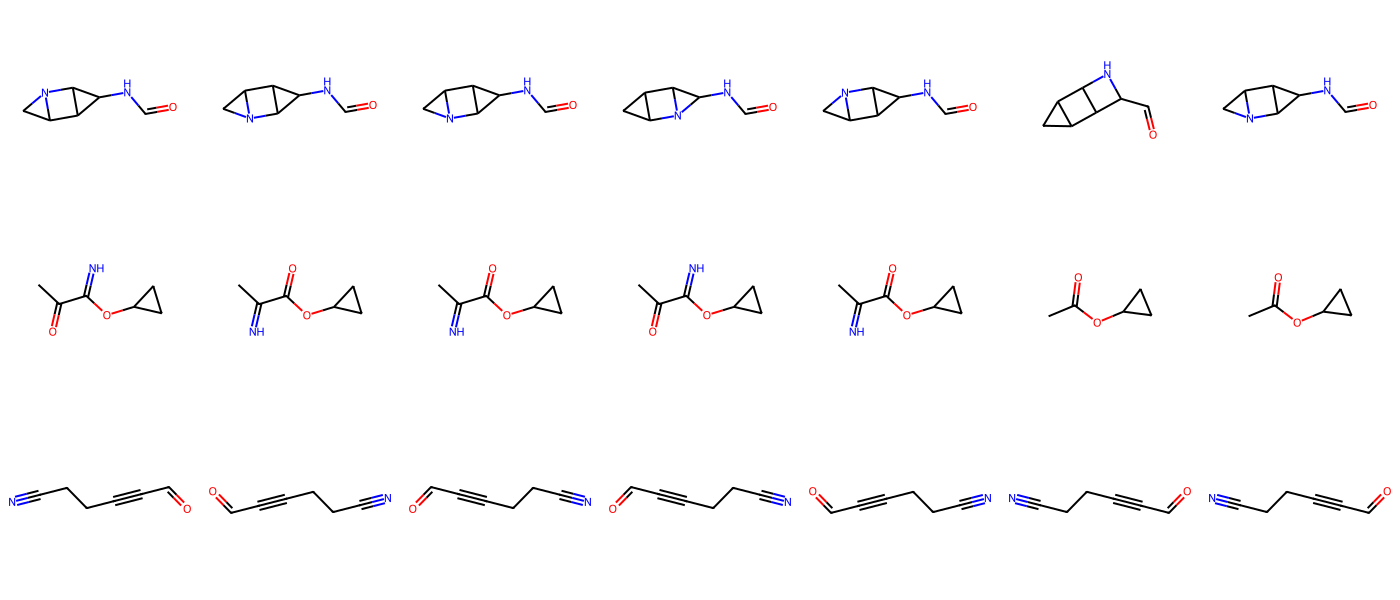

In [17]:
img = Draw.MolsToGridImage(arr[:21], molsPerRow=7, returnPNG=False)
img


In [18]:
index = 1
specembed = test_specembeds[index]
molembed = test_molembeds[index]

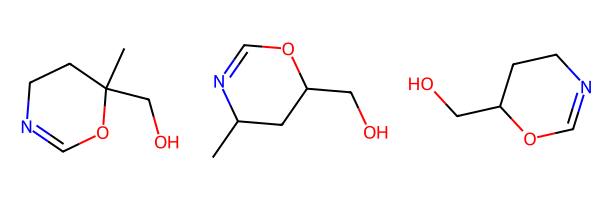

In [19]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=specembed,greedy_decode=False)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

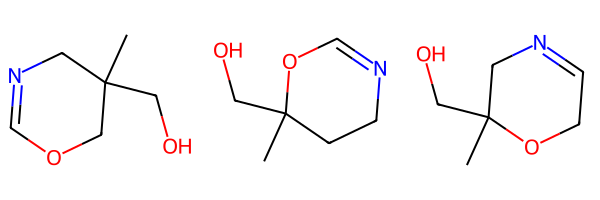

In [20]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=molembed,greedy_decode=False)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

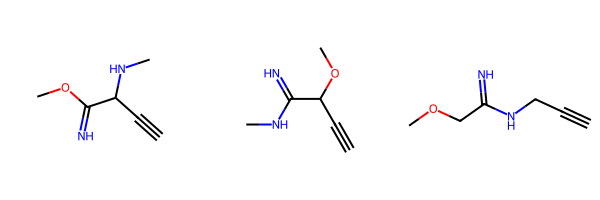

In [21]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=test_specembeds[2] ,greedy_decode=False)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

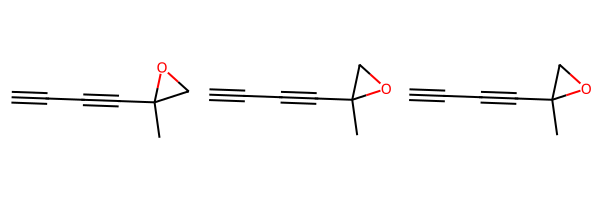

In [22]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=test_specembeds[11] ,greedy_decode=False)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

In [31]:
a = test_specembeds[23]
b = test_specembeds[12]
mp = (a + b) / 2
amp = (a + mp )/ 2
bmp = (b + mp) / 2

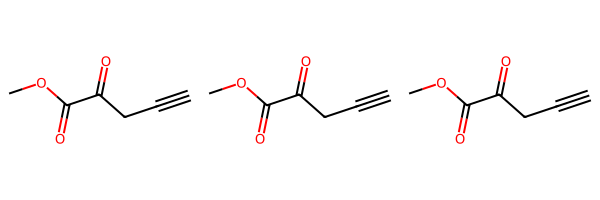

In [32]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=a ,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

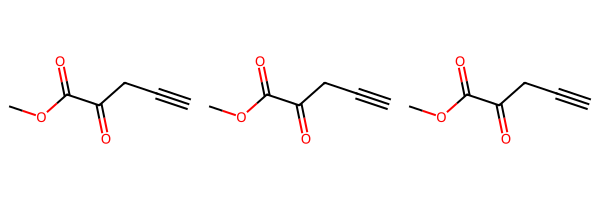

In [33]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed= (a + 7*amp)/8,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

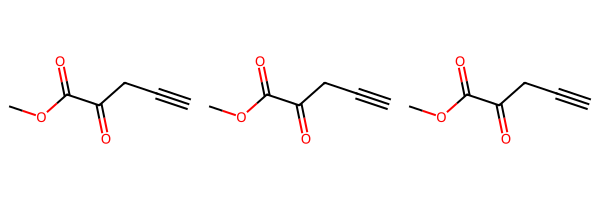

In [34]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=amp ,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

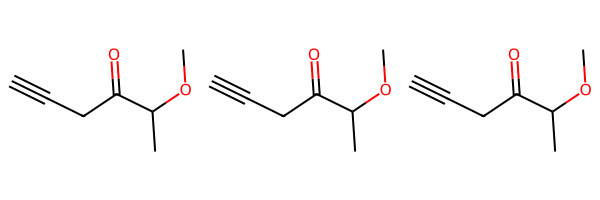

In [35]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=mp ,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

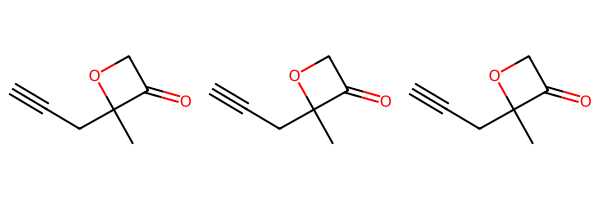

In [36]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=(mp + bmp)/2 ,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

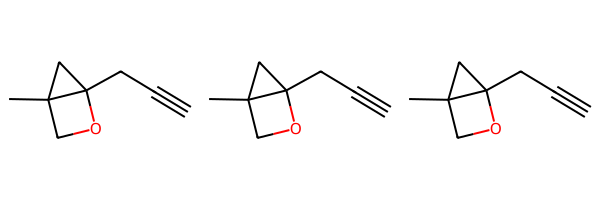

In [37]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=bmp ,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

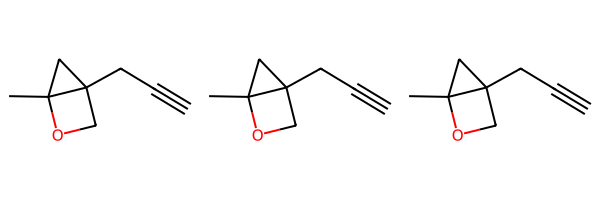

In [38]:
samples = [Chem.MolFromSmiles(smi) for smi in sampler.sample_multi(n=3,embed=b ,greedy_decode=True)]
img = Draw.MolsToGridImage(samples, molsPerRow=len(samples), returnPNG=False)
img

In [162]:
test_smiles_encodings = torch.cat(testsmiles, 0)
test_smiles = []
for enc in test_smiles_encodings:
    og_smile = ""
    chars = model.module.vocab.from_seq(enc)
    for char in chars:
        if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
            og_smile += char
    test_smiles.append(og_smile)

In [163]:
firstid = 123

In [164]:
simmat = test_specembeds @ test_specembeds.T
farthest_id = torch.argmin(simmat[firstid]).item()
embed1 = test_specembeds[firstid]
embed2 = test_specembeds[farthest_id]

In [236]:
def traverse_line(embed1, embed2, n=100):
    embeds = []
    embeds.append(embed1)
    for i in range(1,n):
        embeds.append((embed1*(n-i) + embed2*(i)) / n)
    embeds.append(embed2)
    
    smiles = []
    for embed in embeds:
        smiles.append(sampler.sample_multi(n=1,embed=embed,greedy_decode=True)[0])
    
    mols = []
    for smi in smiles:
        mols.append(Chem.MolFromSmiles(smi))
        
    return mols, smiles, embeds

In [259]:
# mols, smiles, embeds = traverse_line(embed1, embed2, 49)
mols, smiles, embeds = traverse_line(test_specembeds[11], test_specembeds[23], 24)
mols2, smiles, embeds = traverse_line(test_specembeds[23], test_specembeds[1], 24)

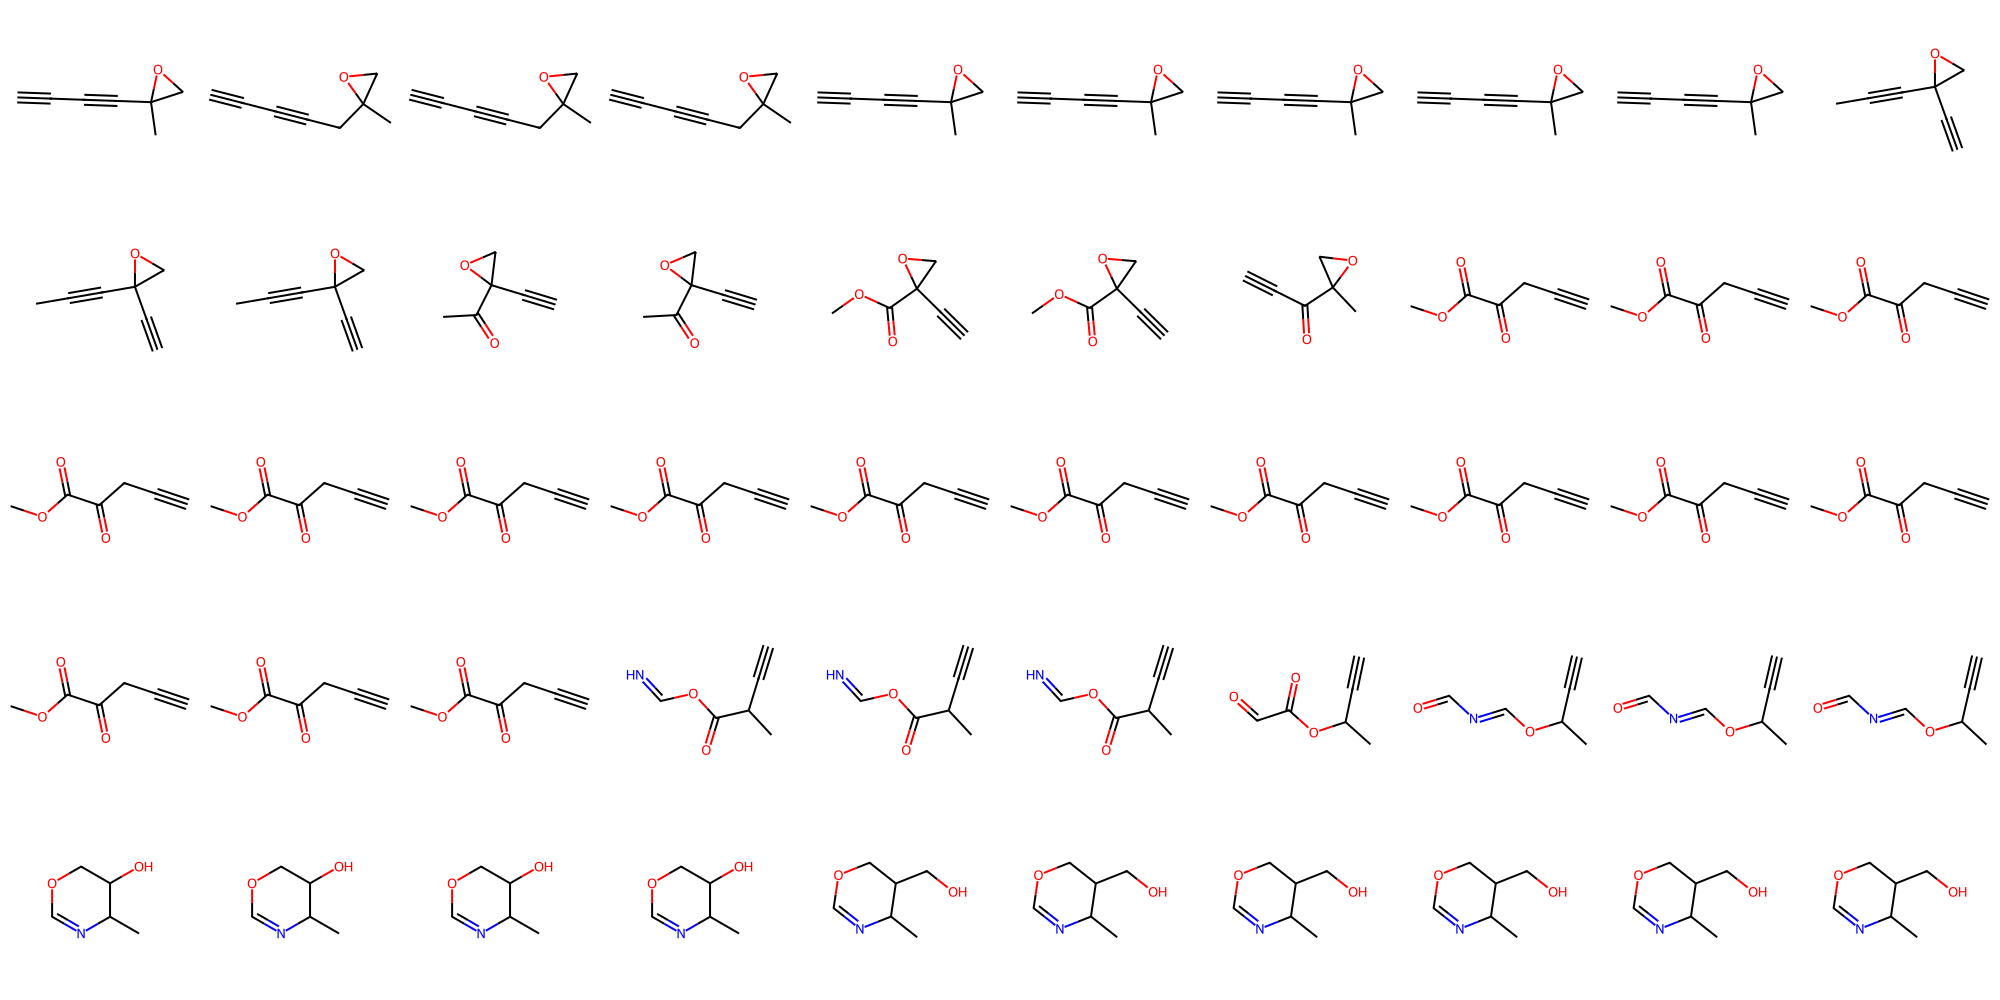

In [260]:
Draw.MolsToGridImage(mols+mols2, molsPerRow=10, returnPNG=False)

In [261]:
c= 0
for mol in mols+mols2:
    img = Draw.MolsToGridImage([mol], molsPerRow=1, returnPNG=False)
    img.save("lineartraverse_imgs/" + str(100 + c) + ".png")
    c+=1

ModuleNotFoundError: No module named 'cv2'

In [222]:
def traverse_plane(embed1, embed2, embed3, embed4, n=10):
    embeds = []
    
    for i in range(n):
        for j in range(n):
            embeds.append((embed1*((n-i)*(n-j)) + embed2*((j)*(n-i)) + embed3*((n-j)*(i)) + embed4*(i)*(j)) / n*n)
    
    smiles = []
    for embed in embeds:
        smiles.append(sampler.sample_multi(n=1,embed=embed,greedy_decode=True)[0])
    
    mols = []
    for smi in smiles:
        mols.append(Chem.MolFromSmiles(smi))
        
    return mols, smiles, embeds

In [223]:
mols, smiles, embeds = traverse_plane(test_specembeds[2], test_specembeds[3], test_specembeds[4], test_specembeds[5], 10)

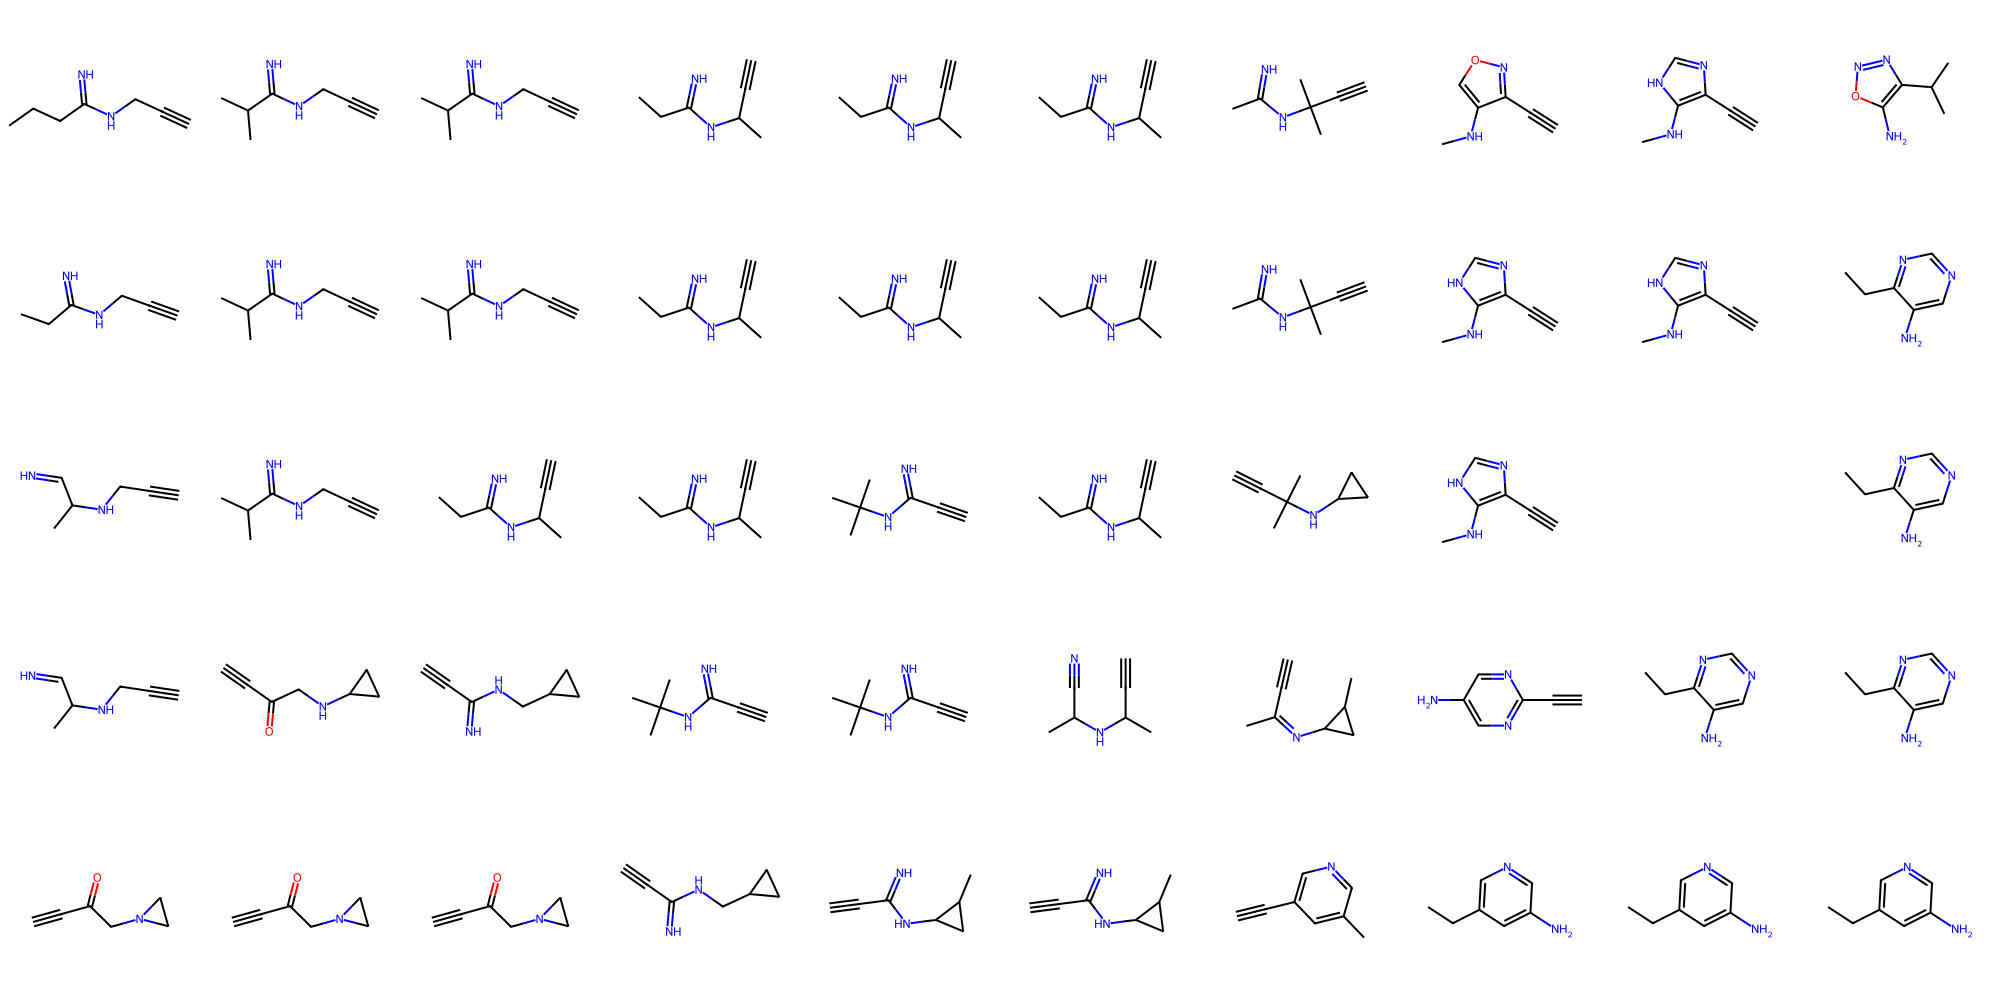

In [224]:
Draw.MolsToGridImage(mols[:50], molsPerRow=10, returnPNG=False)

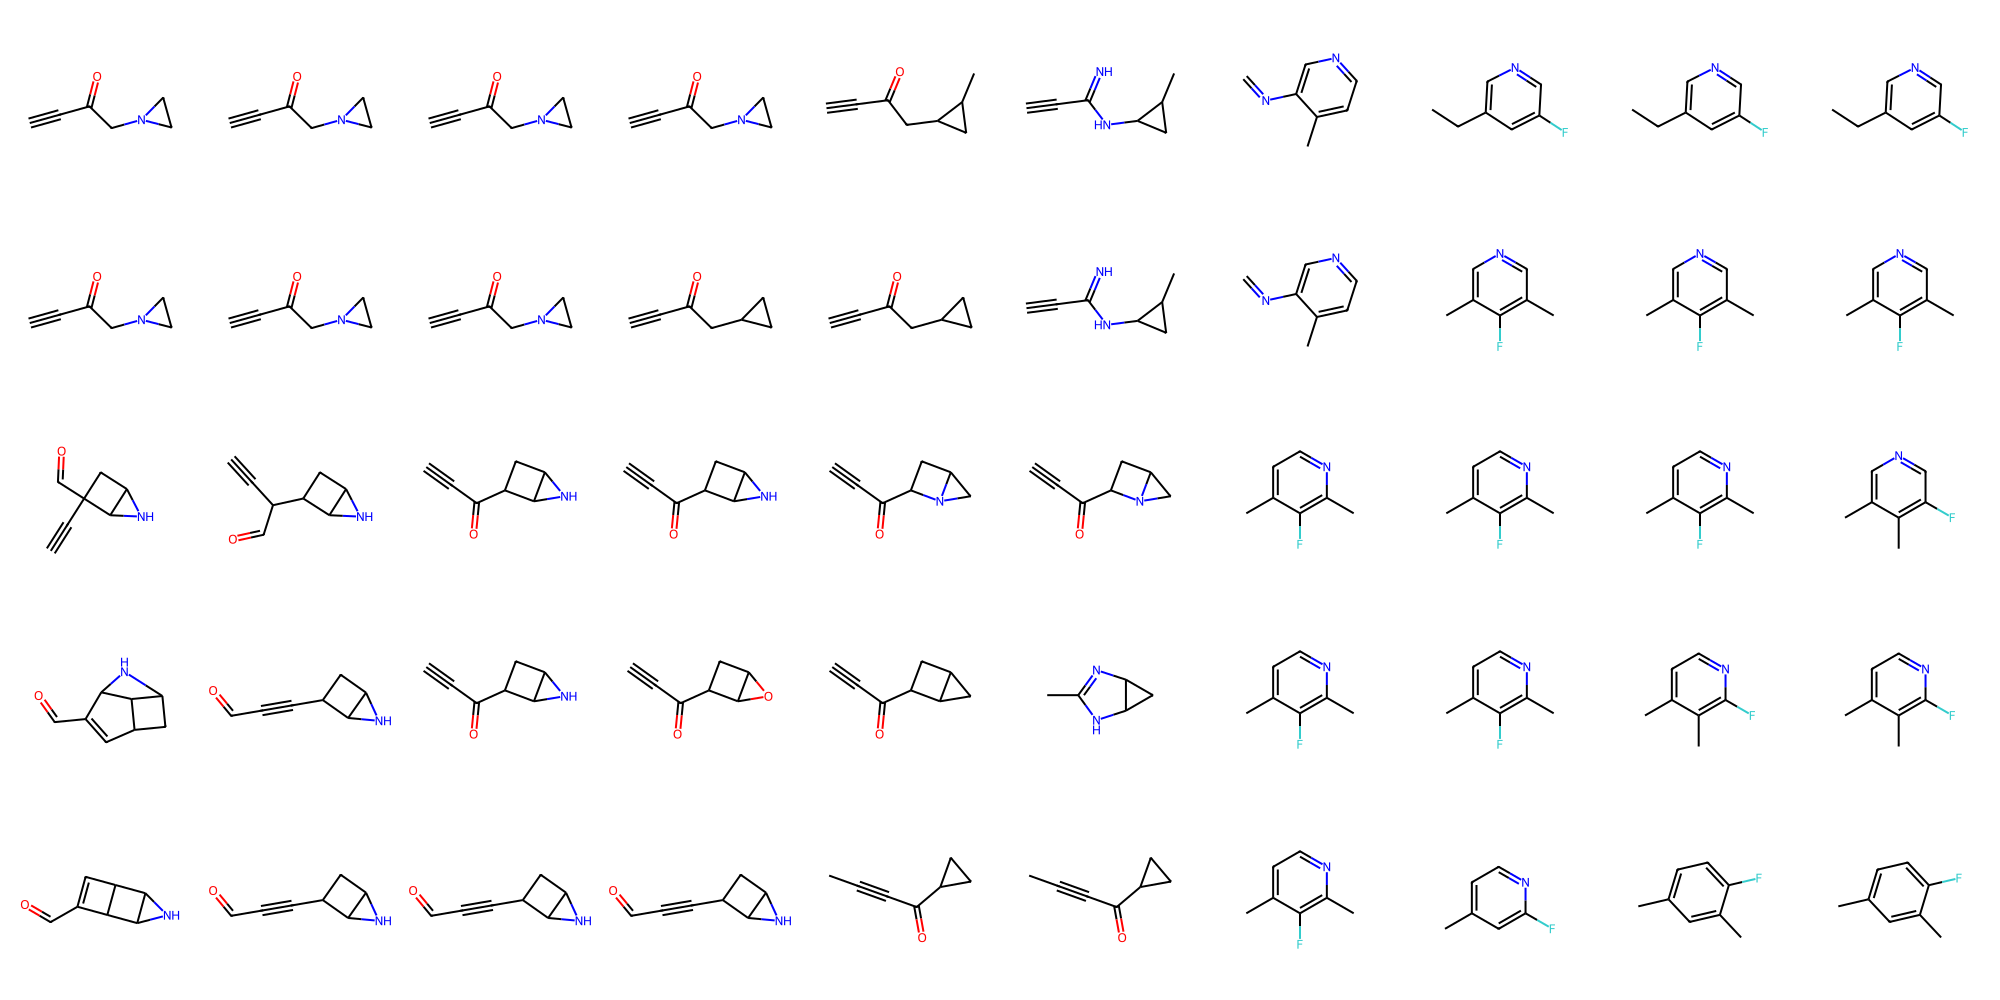

In [225]:
Draw.MolsToGridImage(mols[50:], molsPerRow=10, returnPNG=False)